In [1]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from torchvision import transforms

In [2]:
IMAGE_DIR = "wikiart"
STYLE_CLASS_PATH = "ArtGAN/style_class.txt"
STYLE_VAL_PATH = "ArtGAN/style_val.csv"
GENRE_CLASS_PATH = "ArtGAN/genre_class.txt"
GENRE_VAL_PATH = "ArtGAN/genre_val.csv"
ARTIST_CLASS_PATH = "ArtGAN/artist_class.txt"
ARTIST_VAL_PATH = "ArtGAN/artist_val.csv"
MODEL_OUTPUT_NAME = "model.pth"
BATCH_SIZE = 32

In [3]:
def load_val_data(class_path, val_path):
    with open(class_path, "r") as f:
        class_lines = f.readlines()
        class_lines = [line.strip().split(" ") for line in class_lines]
    class_mapping = {int(line[0]): line[1] for line in class_lines}
    val_data = pd.read_csv(val_path, header=None)
    val_data.columns=["path", "actual"]
    val_data["pred"] = pd.Series([pd.NA] * len(val_data), dtype="Int64")
    val_data["score"] = None
    return class_mapping, val_data

style_class_mapping, style_val_data = load_val_data(STYLE_CLASS_PATH, STYLE_VAL_PATH)
genre_class_mapping, genre_val_data = load_val_data(GENRE_CLASS_PATH, GENRE_VAL_PATH)
artist_class_mapping, artist_val_data = load_val_data(ARTIST_CLASS_PATH, ARTIST_VAL_PATH)

image_paths = set()
for data in [style_val_data, genre_val_data, artist_val_data]:
    image_paths.update(data.iloc[:, 0].values)
image_paths = list(image_paths)

In [4]:
model = torch.load(MODEL_OUTPUT_NAME, weights_only=False)
model.eval()

ArtClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): GRU(64, 32, batch_first=True, bidirectional=True)
  (style_fc): Linear(in_features=64, out_features=27, bias=True)
  (genre_fc): Linear(in_features=64, out_features=10, bias=True)
  (artist_fc): Linear(in_features=64, out_features=23, bias=True)
)

In [5]:
transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
num_batches = int(np.ceil(len(image_paths) / BATCH_SIZE))
for i in range(num_batches):
    paths = image_paths[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
    images = [transform(Image.open(os.path.join(IMAGE_DIR, path))) for path in paths]
    images = torch.stack(images)

    with torch.no_grad():
        style_scores, genre_scores, artist_scores = model(images)
        style_scores = style_scores.numpy()
        genre_scores = genre_scores.numpy()
        artist_scores = artist_scores.numpy()

    for df, scores in zip([style_val_data, genre_val_data, artist_val_data], 
                          [style_scores, genre_scores, artist_scores]):
        valid_paths = df["path"].isin(paths)
        if valid_paths.any():
            preds = np.argmax(scores, axis=1)
            path_to_pred = dict(zip(paths, preds))
            path_to_score = dict(zip(paths, scores))
            df.loc[valid_paths, "pred"] = df.loc[valid_paths, "path"].map(path_to_pred)
            df.loc[valid_paths, "score"] = df.loc[valid_paths, "path"].map(path_to_score)

## Overall Accuracy

In [6]:
style_acc = accuracy_score(style_val_data["actual"], style_val_data["pred"])
genre_acc = accuracy_score(genre_val_data["actual"], genre_val_data["pred"])
artist_acc = accuracy_score(artist_val_data["actual"], artist_val_data["pred"])
print(f"Style Accuracy: {style_acc}")
print(f"Genre Accuracy: {genre_acc}")
print(f"Artist Accuracy: {artist_acc}")

Style Accuracy: 0.11420498751074895
Genre Accuracy: 0.4142212189616253
Artist Accuracy: 0.30003505082369436


#### But the classes are imbalanced, especially for style classification, accuracy may not be an appropriate metric.

## AUC

In [7]:
style_auc = roc_auc_score(style_val_data["actual"], np.vstack(style_val_data["score"].values),
              average="macro", multi_class="ovo")
genre_auc = roc_auc_score(genre_val_data["actual"], np.vstack(genre_val_data["score"].values),
              average="macro", multi_class="ovo")
artist_auc = roc_auc_score(artist_val_data["actual"], np.vstack(artist_val_data["score"].values),
              average="macro", multi_class="ovo")
print(f"Style AUC: {style_auc}")
print(f"Genre AUC: {genre_auc}")
print(f"Artist AUC: {artist_auc}")

Style AUC: 0.7949639920165564
Genre AUC: 0.8086682043716522
Artist AUC: 0.8140011069213126


## Confusion Matrix

In [8]:
def plot_confusion_matrix(actual, pred, class_mapping, name):
    labels = sorted(list(class_mapping.keys()))
    cm = confusion_matrix(actual, pred, labels=labels)
    cm = cm / cm.sum(axis=1, keepdims=True)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm[::-1], fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels[::-1])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

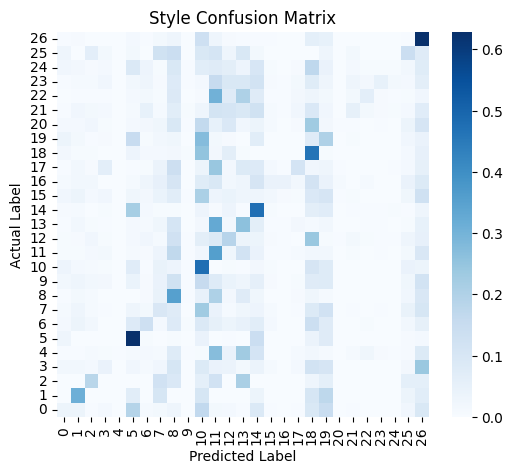

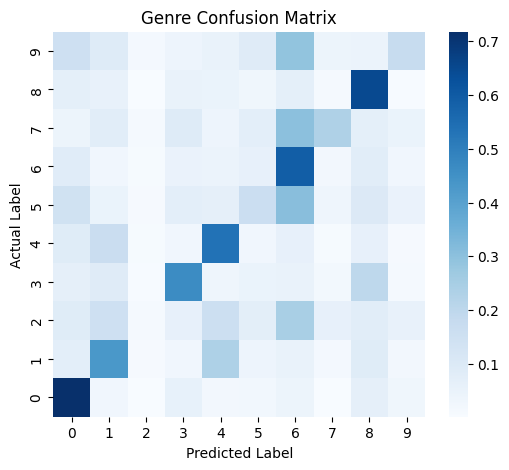

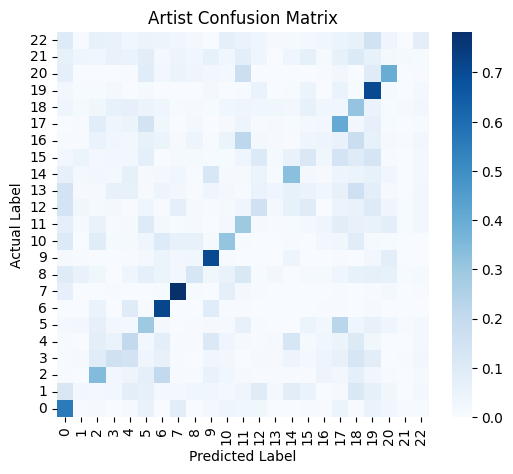

In [9]:
plot_confusion_matrix(
    style_val_data["actual"], 
    style_val_data["pred"],
    style_class_mapping,
    "Style"
)
plot_confusion_matrix(
    genre_val_data["actual"], 
    genre_val_data["pred"],
    genre_class_mapping,
    "Genre"
)
plot_confusion_matrix(
    artist_val_data["actual"], 
    artist_val_data["pred"],
    artist_class_mapping,
    "Artist"
)